In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import urllib.request
import numpy as np
from google.colab.patches import cv2_imshow # cv2_imshow(img)


import IPython.display as display

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
# image urls
attack_a1 = '//assetstorev1-prd-cdn.unity3d.com/preview/031b58f9.9b53b829-1815-4c1e-9827-41ba05514156.png'
attack_a2 = '//assetstorev1-prd-cdn.unity3d.com/preview/031b5a9a.5fbf95c6-105e-4d01-9a8e-37919f8eece3.png'
attack_a3 = '//assetstorev1-prd-cdn.unity3d.com/preview/031b59bf.28cb3708-9977-4ecc-b751-fd182d8991e5.png'
attack_a4 = '//assetstorev1-prd-cdn.unity3d.com/preview/031b59b3.b554df85-def5-44b6-84ac-8aa622318636.png'
attack_a5 = '//assetstorev1-prd-cdn.unity3d.com/preview/031b5998.6178bf29-9b1c-4de5-ae35-52b47b176c1d.png'
attack_a6 = '//assetstorev1-prd-cdn.unity3d.com/preview/031b599b.103e56ad-7ff5-4674-bf4a-cf6e881df46c.png'
attack_imgs = [attack_a1, attack_a2, attack_a3, attack_a4, attack_a5,attack_a6]

# style image download
#style_url = 'https://c402277.ssl.cf1.rackcdn.com/photos/14894/images/hero_small/XL_279141.jpg'
style_url = 'http://artisty.co.kr/custom/img/upload/thumb/14018_m11_thumb.jpg'
style_location = '/content/drive/MyDrive/Colab Notebooks/data/style.png'
urllib.request.urlretrieve(style_url, style_location)

('/content/drive/MyDrive/Colab Notebooks/data/style.png',
 <http.client.HTTPMessage at 0x7ff08c0a6e90>)

In [ ]:
#for idx, url in enumerate(attack_imgs):
idx = 0
url = 'https:' + attack_a1
filename = 'attack_a' + str(idx+1)

# mask 만들기 위한 img download
location = f'/content/drive/MyDrive/Colab Notebooks/data/{filename}.png'
urllib.request.urlretrieve(url, location)

('/content/drive/MyDrive/Colab Notebooks/data/attack_a1.png',
 <http.client.HTTPMessage at 0x7ff08c097610>)

(384, 512)


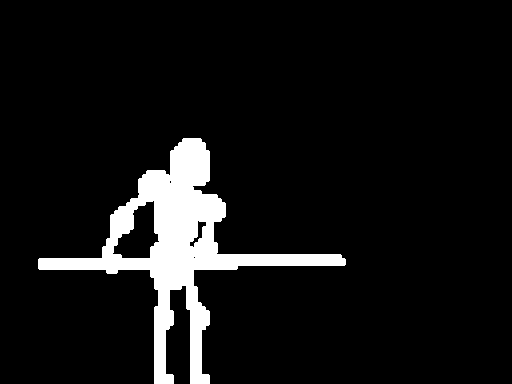

In [ ]:
# mask 만들기
img = cv2.imread(location,cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, dsize=(512,384))
# 픽셀 값이 4 보다 크면 255로 바꿈 아니면 0으로 
_, mask = cv2.threshold(img[:,:,3], 4, 255, cv2.THRESH_BINARY)
# mask 확인
print(mask.shape)
cv2_imshow(mask)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_image = load_img(location)
style_image = load_img(style_location)

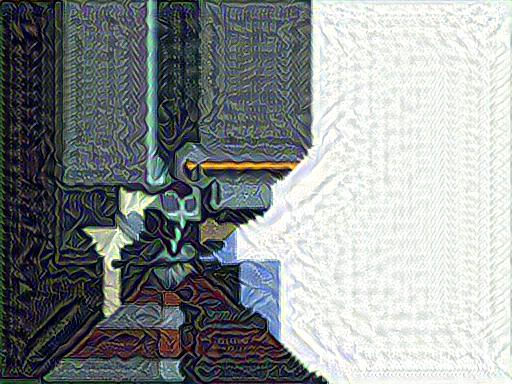

훈련 스텝: 20


In [ ]:
def vgg_layers(layer_names):
    #""" 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
    # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "[0,1] 사이의 실수 값을 입력으로 받습니다"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                        outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}


def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                        for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

#def get_transformed_img(content_image, style_image):
    # 
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape
#
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
#
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
# 
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
#
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
#
image = tf.Variable(content_image)
#
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
#
style_weight=1e-2
content_weight=1e4
#
epochs = 20
steps_per_epoch = 2
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
#display.clear_output(wait=True)
#display.display(tensor_to_image(image))
#print("훈련 스텝: {}".format(step))
img_transformed = np.array(tensor_to_image(image))
    #return img_transformed

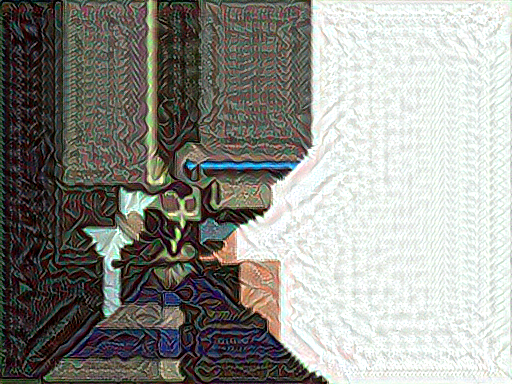

In [ ]:
cv2_imshow(img_transformed)

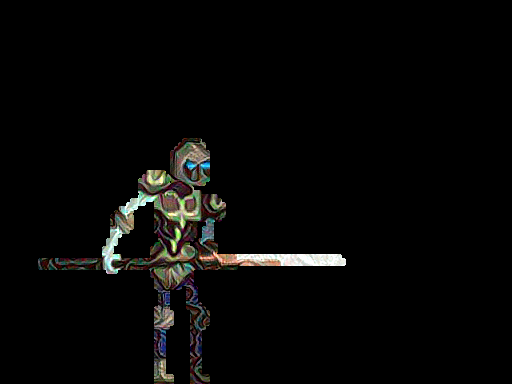

In [ ]:
# transformed에 mask 적용
img_masked = cv2.bitwise_and(img_transformed, img_transformed, mask=mask)
#cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/data/{filename}_masked.png', img_masked)
cv2_imshow(img_masked)